# Preprocessing trial acquisitions (calcium imaging)
* Creating summed images
* Rigid motion correction (phase correlation)
* Deformable motion correction (optical flow)



In [1]:
import numpy as np
import os

from matplotlib import pyplot as plt
import napari

from math import sqrt
from scipy.ndimage import shift
from skimage.registration import phase_cross_correlation,optical_flow_ilk
from skimage.transform import warp
from skimage.exposure import match_histograms

from scripts.sample_db import SampleDB
from scripts.utils import image_utils

from tifffile import imwrite


In [2]:
# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path) 
print(sample_db)

SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3'])


In [3]:
# Loading experiment 
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)
print(exp)

sample=Sample(id='20220426_RM0008_130hpf_fP1_f3', parents_id='P1', genotype='aTubulin:GCamp6s x GAD1b:DsRed', phenotype='positive expression, nacre', dof='21.04.2022-09:30', hpf=130, body_length_mm=4) params_odor=ParamsOdor(odor_list=['Ala', 'Ser', 'Ctrl', 'TCA', 'GCA', 'TDCA', 'Cad', 'SA'], odor_sequence=['Ala', 'Ser', 'Ctrl', 'TCA', 'GCA', 'TDCA', 'Cad', 'SA', 'Cad', 'TDCA', 'GCA', 'TCA', 'Ser', 'Ctrl', 'Ala', 'SA', 'Ctrl', 'Cad', 'Ala', 'Ser', 'TDCA', 'GCA', 'TCA', 'SA'], odor_concentration_uM=[OdorConcentration(name='Ala', concentration_mM=100.0), OdorConcentration(name='Ser', concentration_mM=100.0), OdorConcentration(name='Ctrl', concentration_mM=100.0), OdorConcentration(name='TCA', concentration_mM=10.0), OdorConcentration(name='GCA', concentration_mM=10.0), OdorConcentration(name='TDCA', concentration_mM=10.0), OdorConcentration(name='Cad', concentration_mM=300.0), OdorConcentration(name='SA', concentration_mM=0.0)], n_trials=3, pulse_delay_s=15, pulse_duration_s=5, trial_inte

In [4]:
#Making shortcuts of sample parameters/information 
sample = exp.sample
raw_path = exp.paths["raw_path"]
anatomy_path = exp.paths["anatomy_path"]
em_path = exp.paths["em_path"]
n_planes = exp.params_lm.n_planes
n_frames =  exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range

# Calculating number of frames per trial (TODO: add it to config file) 
n_frames_trial = n_frames // n_planes

In [5]:
# Getting paths of the trial acquisitions 
trial_paths = os.listdir(os.path.join(raw_path,"trials"))
print(trial_paths)


['20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t1_o3Ctrl_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t1_o4TCA_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t1_o5GCA_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t1_o6TDCA_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t1_o7Cad_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t1_o8SA_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t2_o1Ala_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t2_o2Ser_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t2_o3Ctrl_002_.tif', '20220426_RM0008_130hpf_fP1_f3_t2_o4TCA_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t2_o5GCA_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t2_o6TDCA_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t2_o7Cad_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t2_o8SA_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t3_o1Ala_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t3_o2Ser_001_.tif', '20220426_RM0008_130hpf_fP1_f3_t3_o3Ctrl_001_.tif', '20220426_RM0008_130hpf_fP1

In [6]:
# Loading trial acquisitions and computing sum (from ignore frame) 
ignore_until_frame = 75 # edit if you want to avoid summing out motor movements at the beginning of acquisition 

ref_images = np.stack([image_utils.load_tiff_as_hyperstack(os.path.join(raw_path, "trials", trial_path), n_channels=1, n_slices = n_planes, doubling=True)[:,ignore_until_frame:,:,:].sum(axis=1) for trial_path in trial_paths])

print(ref_images.shape)

(24, 8, 256, 512)


In [7]:
ref_images.shape

(24, 8, 256, 512)

In [8]:
n_trials = ref_images.shape[0]  #(TODO: add it to config file)

In [9]:
# Define the path for the preprocessed folder
preprocessed_folder = os.path.join(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3", "preprocessed")

#TODO: Add exp path to config file
os.makedirs(preprocessed_folder, exist_ok=True)

In [86]:
for plane in range(n_planes):
    for trial in range(n_trials):
        summed_frame_path = os.path.join(preprocessed_folder, f"sum_plane_{plane:02d}_{trial_paths[trial]}")
        imwrite(summed_frame_path, ref_images[:, plane, :, :])
        print(f"Summed frame for plane {plane} saved at {summed_frame_path}")

Summed frame for plane 0 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\sum_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif
Summed frame for plane 0 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\sum_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_.tif
Summed frame for plane 0 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\sum_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o3Ctrl_001_.tif
Summed frame for plane 0 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\sum_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o4TCA_001_.tif
Summed frame for plane 0 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\sum_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o5GCA_001_.tif
Summed frame for plane 0 saved at \\tungsten-nas.

In [ ]:
# Compute phase correlation for each frame against the reference
rigid_params_path = os.path.join(preprocessed_folder, "rigid_params.npy")
elastic_params_path = os.path.join(preprocessed_folder, "elastic_params.npy")

rigid_params = []
elastic_params = []

Xs = np.zeros((n_trials, n_planes))
Ys = np.zeros((n_trials, n_planes))
total_motion = np.zeros((n_trials, n_planes))

for plane in range(n_planes):
    print(f"Processing plane {plane}")
    for ii in range(n_trials):
        X = phase_cross_correlation(ref_images[0, plane, :, :], ref_images[ii, plane, :, :], upsample_factor=5, space='real')
        Xs[ii, plane] = X[0][0]  # x-displacement
        Ys[ii, plane] = X[0][1]  # y-displacement
        total_motion[ii, plane] = sqrt(Xs[ii, plane] ** 2 + Ys[ii, plane] ** 2)
     
    rigid_params.append((Xs, Ys))
        

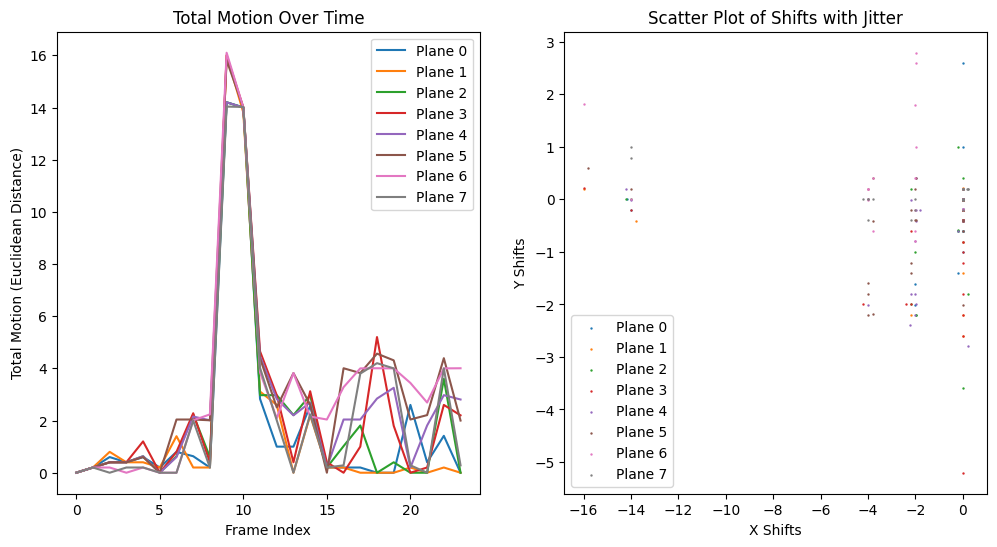

In [92]:
# Plot total motion and shifts 
plt.figure(figsize=(12, 6))

# Plot total motion over time for each plane
plt.subplot(1, 2, 1)
for plane in range(n_planes*2):
    plt.plot(total_motion[:, plane], label=f'Plane {plane}')
plt.title("Total Motion Over Time")
plt.xlabel("Frame Index")
plt.ylabel("Total Motion (Euclidean Distance)")
plt.legend()

# Scatter plot of shifts for each plane
plt.subplot(1, 2, 2)
for plane in range(n_planes*2):
    plt.scatter(Xs[:, plane] - 0.01 + 0.02 * np.random.rand(Xs[:, plane].size), 
                Ys[:, plane] - 0.01 + 0.02 * np.random.rand(Ys[:, plane].size), s=0.5, label=f'Plane {plane}')
plt.title("Scatter Plot of Shifts with Jitter")
plt.xlabel("X Shifts")
plt.ylabel("Y Shifts")
plt.legend()

plt.show()

In [89]:
# Align trial images to reference

aligned_frames = np.zeros_like(ref_images)

for plane in range(n_planes):
    for trial in range(n_trials):
        current_frame = ref_images[trial, plane, :, :]
        shift_values = (Xs[trial, plane], Ys[trial, plane])

        # Ensure shift_values has the correct length
        if len(shift_values) != current_frame.ndim:
            raise ValueError("shift_values length must match the number of dimensions of current_frame")

        shifted_frame = shift(current_frame, shift_values, order=3, prefilter=True)
        
        # Match the histogram of the shifted frame to the reference frame
        aligned_frames[trial, plane, :, :] = match_histograms(shifted_frame, ref_images[trial, plane, :, :])

        # Save rigid corrected frame
        rigid_corrected_path = os.path.join(preprocessed_folder, f"rigid_corrected_plane_{plane:02d}_{trial_paths[trial]}")
        imwrite(rigid_corrected_path, aligned_frames[trial, plane, :, :])
        print(f"Rigid corrected frame for plane {plane}, trial {trial} saved at {rigid_corrected_path}")




Rigid corrected frame for plane 0, trial 0 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\rigid_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif
Rigid corrected frame for plane 0, trial 1 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\rigid_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_.tif
Rigid corrected frame for plane 0, trial 2 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\rigid_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o3Ctrl_001_.tif
Rigid corrected frame for plane 0, trial 3 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\rigid_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o4TCA_001_.tif
Rigid corrected frame for plane 0, trial 4 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData

In [64]:
# Visualize the alignment 
viewer = napari.Viewer()

viewer.add_image(ref_images, name='ref_frames')
viewer.add_image(aligned_frames, name='aligned_images')

<Image layer 'aligned_images' at 0x1cca0309240>

In [90]:
# --- Compute the optical flow with reference to first image

# Prepare an array to store the warped movie frames
warped_movie = np.zeros_like(aligned_frames)

for plane in range(n_planes):
    ref_image = aligned_frames[0, plane]
    nr, nc = ref_image.shape
    # Compute the optical flow and warp each frame
    print(f"Starting plane {plane}")
   
    for trial in range(n_trials):
        print(f"Warping frame {trial+1}/{n_trials}")
        frame = aligned_frames[trial, plane, :,: ]
        # Compute optical flow
        v, u = optical_flow_ilk(ref_image, frame , radius=15)
        
        # Create mesh grid for coordinates
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
        
        # Warp the current frame
        warped_frame = warp(frame, np.array([row_coords + v, col_coords + u]), mode='edge')
        warped_frame = match_histograms(warped_frame, ref_image)
        
        # Store the warped frame
        warped_movie[trial, plane, :, :] = warped_frame
        
                # Save elastic corrected frame
        elastic_corrected_path = os.path.join(preprocessed_folder, f"elastic_corrected_plane_{plane:02d}_{trial_paths[trial]}")
        imwrite(elastic_corrected_path, warped_frame)
        print(f"Elastic corrected frame for plane {plane}, trial {trial} saved at {elastic_corrected_path}")


Starting plane 0
Warping frame 1/24
Elastic corrected frame for plane 0, trial 0 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\elastic_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif
Warping frame 2/24
Elastic corrected frame for plane 0, trial 1 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\elastic_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_.tif
Warping frame 3/24
Elastic corrected frame for plane 0, trial 2 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\elastic_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o3Ctrl_001_.tif
Warping frame 4/24
Elastic corrected frame for plane 0, trial 3 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\elastic_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o4TCA_001_.tif
Warping fr

In [66]:
viewer.add_image(warped_movie, name='warped_movie')

<Image layer 'warped_movie' at 0x1cc974caa10>

SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3'])
sample=Sample(id='20220426_RM0008_130hpf_fP1_f3', parents_id='P1', genotype='aTubulin:GCamp6s x GAD1b:DsRed', phenotype='positive expression, nacre', dof='21.04.2022-09:30', hpf=130, body_length_mm=4) params_odor=ParamsOdor(odor_list=['Ala', 'Ser', 'Ctrl', 'TCA', 'GCA', 'TDCA', 'Cad', 'SA'], odor_sequence=['Ala', 'Ser', 'Ctrl', 'TCA', 'GCA', 'TDCA', 'Cad', 'SA', 'Cad', 'TDCA', 'GCA', 'TCA', 'Ser', 'Ctrl', 'Ala', 'SA', 'Ctrl', 'Cad', 'Ala', 'Ser', 'TDCA', 'GCA', 'TCA', 'SA'], odor_concentration_uM=[OdorConcentration(name='Ala', concentration_mM=100.0), OdorConcentration(name='Ser', concentration_mM=100.0), OdorConcentration(name='Ctrl', concentration_mM=100.0), OdorConcentration(name='TCA', concentration_mM=10.0), OdorConcentration(name='GCA', concentration_mM=10.0), OdorConcentration(name='TDCA', concentration_mM=10.0), OdorConcentration(name='Cad', concentration_mM=300.0), OdorConcentration(name='SA', concentration_mM=0.0)], n_tri

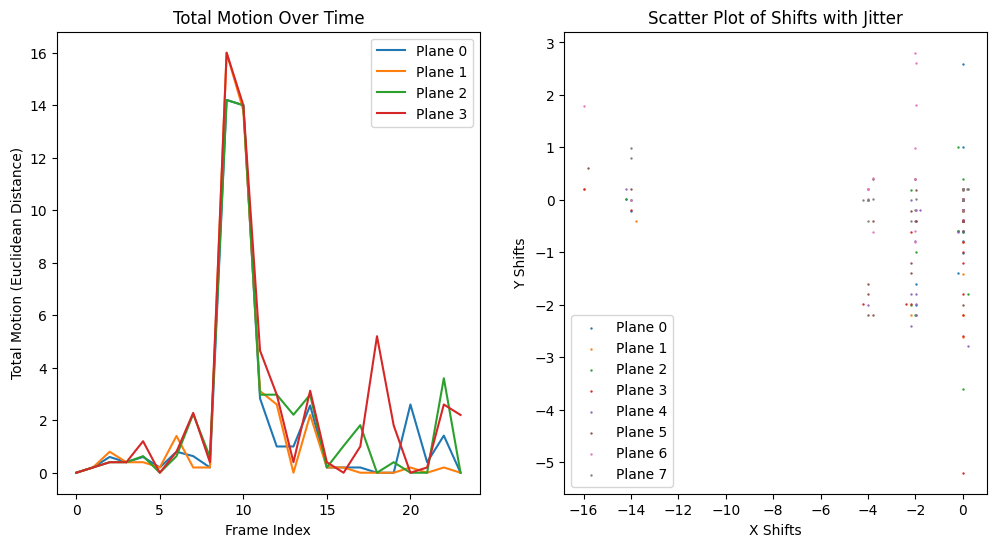

Rigid corrected frame for plane 0, trial 0 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\rigid_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif
Rigid corrected frame for plane 0, trial 1 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\rigid_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_.tif
Rigid corrected frame for plane 0, trial 2 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\rigid_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o3Ctrl_001_.tif
Rigid corrected frame for plane 0, trial 3 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\rigid_corrected_plane_00_20220426_RM0008_130hpf_fP1_f3_t1_o4TCA_001_.tif
Rigid corrected frame for plane 0, trial 4 saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData

<Image layer 'warped_movie' at 0x1e8732e1ab0>

In [11]:
import numpy as np
import os

from matplotlib import pyplot as plt
import napari

from math import sqrt
from scipy.ndimage import shift
from skimage.registration import phase_cross_correlation, optical_flow_ilk
from skimage.transform import warp
from skimage.exposure import match_histograms

from scripts.sample_db import SampleDB
from scripts.utils import image_utils

from tifffile import imwrite

# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)
# Loading experiment 
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)
print(exp)
# Making shortcuts of sample parameters/information 
sample = exp.sample
raw_path = exp.paths["raw_path"]
anatomy_path = exp.paths["anatomy_path"]
em_path = exp.paths["em_path"]
n_planes = exp.params_lm.n_planes
n_frames = exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range
doubling = 2 if exp.params_lm.doubling else 1

# Calculating number of frames per trial (TODO: add it to config file) 
n_frames_trial = n_frames // n_planes
# Getting paths of the trial acquisitions 
trial_paths = os.listdir(os.path.join(raw_path, "trials"))
print(trial_paths)

# Loading trial acquisitions and computing sum (from ignore frame) 
ignore_until_frame = 75  # edit if you want to avoid summing out motor movements at the beginning of acquisition 

ref_images = np.stack([image_utils.load_tiff_as_hyperstack(os.path.join(raw_path, "trials", trial_path), n_channels=1,
                                                           n_slices=n_planes, doubling=True)[:, ignore_until_frame:, :,
                       :].sum(axis=1) for trial_path in trial_paths])

print(ref_images.shape)
ref_images.shape
n_trials = ref_images.shape[0]  #(TODO: add it to config file)
# Define the path for the preprocessed folder
preprocessed_folder = os.path.join(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3",
                                   "preprocessed")

#TODO: Add exp path to config file
os.makedirs(preprocessed_folder, exist_ok=True)
for plane in range(n_planes*doubling):
    for trial in range(n_trials):
        summed_frame_path = os.path.join(preprocessed_folder, f"sum_plane_{plane:02d}_{trial_paths[trial]}")
        imwrite(summed_frame_path, ref_images[:, plane, :, :])
        print(f"Summed frame for plane {plane} saved at {summed_frame_path}")

# Compute phase correlation for each frame against the reference
rigid_params_path = os.path.join(preprocessed_folder, "rigid_params.npy")
elastic_params_path = os.path.join(preprocessed_folder, "elastic_params.npy")

rigid_params = []
elastic_params = []

Xs = np.zeros((n_trials, n_planes*doubling))
Ys = np.zeros((n_trials, n_planes*doubling))
total_motion = np.zeros((n_trials, n_planes*doubling))

for plane in range(n_planes*doubling):
    print(f"Processing plane {plane}")
    for ii in range(n_trials):
        X = phase_cross_correlation(ref_images[0, plane, :, :], ref_images[ii, plane, :, :], upsample_factor=5,
                                    space='real')
        Xs[ii, plane] = X[0][0]  # x-displacement
        Ys[ii, plane] = X[0][1]  # y-displacement
        total_motion[ii, plane] = sqrt(Xs[ii, plane] ** 2 + Ys[ii, plane] ** 2)

    rigid_params.append((Xs[:, plane], Ys[:, plane]))

# Save the rigid transformation parameters
np.save(rigid_params_path, rigid_params)
print(f"Rigid transformation parameters saved at {rigid_params_path}")

# Plot total motion and shifts 
plt.figure(figsize=(12, 6))

# Plot total motion over time for each plane
plt.subplot(1, 2, 1)
for plane in range(n_planes):
    plt.plot(total_motion[:, plane], label=f'Plane {plane}')
plt.title("Total Motion Over Time")
plt.xlabel("Frame Index")
plt.ylabel("Total Motion (Euclidean Distance)")
plt.legend()

# Scatter plot of shifts for each plane
plt.subplot(1, 2, 2)
for plane in range(n_planes*doubling):
    plt.scatter(Xs[:, plane] - 0.01 + 0.02 * np.random.rand(Xs[:, plane].size),
                Ys[:, plane] - 0.01 + 0.02 * np.random.rand(Ys[:, plane].size), s=0.5, label=f'Plane {plane}')
plt.title("Scatter Plot of Shifts with Jitter")
plt.xlabel("X Shifts")
plt.ylabel("Y Shifts")
plt.legend()

plt.show()
# Align trial images to reference

aligned_frames = np.zeros_like(ref_images)

for plane in range(n_planes*doubling):
    for trial in range(n_trials):
        current_frame = ref_images[trial, plane, :, :]
        shift_values = (Xs[trial, plane], Ys[trial, plane])

        # Ensure shift_values has the correct length
        if len(shift_values) != current_frame.ndim:
            raise ValueError("shift_values length must match the number of dimensions of current_frame")

        shifted_frame = shift(current_frame, shift_values, order=3, prefilter=True)

        # Match the histogram of the shifted frame to the reference frame
        aligned_frames[trial, plane, :, :] = match_histograms(shifted_frame, ref_images[trial, plane, :, :])

        # Save rigid corrected frame
        rigid_corrected_path = os.path.join(preprocessed_folder,
                                            f"rigid_corrected_plane_{plane:02d}_{trial_paths[trial]}")
        imwrite(rigid_corrected_path, aligned_frames[trial, plane, :, :])
        print(f"Rigid corrected frame for plane {plane}, trial {trial} saved at {rigid_corrected_path}")

# Visualize the alignment 
viewer = napari.Viewer()

viewer.add_image(ref_images, name='ref_frames')
viewer.add_image(aligned_frames, name='aligned_images')

# Compute the optical flow for elastic transformation and apply it

warped_movie = np.zeros_like(aligned_frames)

for plane in range(n_planes*doubling):
    ref_image = aligned_frames[0, plane]
    nr, nc = ref_image.shape
    elastic_plane_params = []

    # Compute the optical flow and warp each frame
    print(f"Starting plane {plane}")

    for trial in range(n_trials):
        print(f"Warping frame {trial + 1}/{n_trials}")
        frame = aligned_frames[trial, plane, :, :]
        # Compute optical flow
        v, u = optical_flow_ilk(ref_image, frame, radius=15)

        # Save the elastic transformation parameters
        elastic_plane_params.append((v, u))

        # Create mesh grid for coordinates
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')

        # Warp the current frame
        warped_frame = warp(frame, np.array([row_coords + v, col_coords + u]), mode='edge')
        warped_frame = match_histograms(warped_frame, ref_image)

        # Store the warped frame
        warped_movie[trial, plane, :, :] = warped_frame

        # Save elastic corrected frame
        elastic_corrected_path = os.path.join(preprocessed_folder,
                                              f"elastic_corrected_plane_{plane:02d}_{trial_paths[trial]}")
        imwrite(elastic_corrected_path, warped_frame)
        print(f"Elastic corrected frame for plane {plane}, trial {trial} saved at {elastic_corrected_path}")

    elastic_params.append(elastic_plane_params)

# Save the elastic transformation parameters
np.save(elastic_params_path, elastic_params)
print(f"Elastic transformation parameters saved at {elastic_params_path}")

viewer.add_image(warped_movie, name='warped_movie')


In [61]:
%%time
# Process each trial
for trial_idx, trial_path in enumerate(trial_paths):
    print(f"  Processing trial {trial_idx + 1}/{n_trials}")
    raw_movie = image_utils.load_tiff_as_hyperstack(os.path.join(raw_path, "trials", trial_path), n_slices=exp.params_lm.n_planes, doubling=True)

    n_planes, n_frames, height, width = raw_movie.shape
    transformed_movie = np.zeros_like(raw_movie)
    
    for plane in range(n_planes):
        print(f"  Processing plane {plane + 1}/{n_planes}")
        Xs, Ys = rigid_params[plane][0][trial_idx], rigid_params[plane][1][trial_idx]
        print(Xs, Ys)
        v, u = elastic_params[plane][trial_idx][0], elastic_params[plane][trial_idx][1]
        
        for frame in range(n_frames):
            
            # Apply rigid transformation
            shifted_frame = shift(raw_movie[plane, frame, :, :], (Xs, Ys), order=3, prefilter=True)
            
            # Apply elastic transformation
            row_coords, col_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
            warped_frame = warp(shifted_frame, np.array([row_coords + v, col_coords + u]), mode='edge')
            
            transformed_movie[plane, frame, :, :] = warped_frame
    
    # Save the transformed movie for the current trial
    transformed_trial_path = os.path.join(preprocessed_folder, f"transformed_{trial_path}")
    imwrite(transformed_trial_path, transformed_movie)
    print(f"  Transformed trial {trial_path} saved at {transformed_trial_path}")

print("All trials processed and saved.")

  Processing plane 1/24
  Processing plane 1/8
0.0 0.0
  Processing plane 2/8
0.0 0.0
  Processing plane 3/8
0.0 0.0
  Processing plane 4/8
0.0 0.0
  Processing plane 5/8
0.0 0.0
  Processing plane 6/8
0.0 0.0
  Processing plane 7/8
0.0 0.0
  Processing plane 8/8
0.0 0.0
  Transformed trial 20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\transformed_20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif
  Processing plane 2/24
  Processing plane 1/8
0.0 -0.2
  Processing plane 2/8
0.0 -0.2
  Processing plane 3/8
0.0 -0.2
  Processing plane 4/8
0.0 -0.2
  Processing plane 5/8
0.0 -0.2
  Processing plane 6/8
0.0 -0.2
  Processing plane 7/8
0.0 0.2
  Processing plane 8/8
0.0 0.2
  Transformed trial 20220426_RM0008_130hpf_fP1_f3_t1_o2Ser_001_.tif saved at \\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\preprocessed\transformed_20220426_RM0008_130hpf_fP1_f3_t1_o

In [62]:
viewer = napari.Viewer()
viewer.add_image(transformed_movie, name='transformed_movie')
viewer.add_image(raw_movie, name='raw_movie')

<Image layer 'raw_movie' at 0x1e83e1a7250>

In [1]:
%%time
import numpy as np
import os
from tifffile import imwrite
from scipy.ndimage import shift
from skimage.transform import warp
from joblib import Parallel, delayed

from scripts.sample_db import SampleDB
from scripts.utils import image_utils

# Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

# Loading experiment
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)
print(exp)

# Making shortcuts of sample parameters/information
sample = exp.sample
raw_path = exp.paths["raw_path"]
anatomy_path = exp.paths["anatomy_path"]
em_path = exp.paths["em_path"]
n_planes = exp.params_lm.n_planes
n_frames = exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range

# Getting paths of the trial acquisitions
trial_paths = os.listdir(os.path.join(raw_path, "trials"))
print(trial_paths)

# Define the path for the preprocessed folder
preprocessed_folder = os.path.join(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3", "preprocessed")
os.makedirs(preprocessed_folder, exist_ok=True)

# Load transformation parameters
rigid_params_path = os.path.join(preprocessed_folder, "rigid_params.npy")
elastic_params_path = os.path.join(preprocessed_folder, "elastic_params.npy")

rigid_params = np.load(rigid_params_path, allow_pickle=True)
elastic_params = np.load(elastic_params_path, allow_pickle=True)

def process_frame(raw_movie, plane, frame, Xs, Ys, v, u):
    """Apply rigid and elastic transformation to a single frame."""
    # Apply rigid transformation
    shifted_frame = shift(raw_movie[plane, frame, :, :], (Xs, Ys), order=3, prefilter=True)
    
    # Apply elastic transformation
    height, width = shifted_frame.shape
    row_coords, col_coords = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    warped_frame = warp(shifted_frame, np.array([row_coords + v, col_coords + u]), mode='edge')
    
    return warped_frame

# Process each trial in parallel
for trial_idx, trial_path in enumerate(trial_paths):
    print(f"Processing trial {trial_idx + 1}/{len(trial_paths)}")
    raw_movie = image_utils.load_tiff_as_hyperstack(os.path.join(raw_path, "trials", trial_path), n_slices=exp.params_lm.n_planes, doubling=True)

    n_planes, n_frames, height, width = raw_movie.shape
    
    for plane in range(n_planes):
        print(f"  Processing plane {plane + 1}/{n_planes}")
        Xs, Ys = rigid_params[plane][0][trial_idx], rigid_params[plane][1][trial_idx]
        v, u = elastic_params[plane][trial_idx][0], elastic_params[plane][trial_idx][1]
        
        # Process each frame in parallel
        transformed_plane_frames = Parallel(n_jobs=-1)(
            delayed(process_frame)(raw_movie, plane, frame, Xs, Ys, v, u) for frame in range(n_frames)
        )
        
        # Convert list of frames to numpy array
        transformed_plane = np.stack(transformed_plane_frames)
        
        # Save the transformed movie for the current plane
        transformed_plane_path = os.path.join(preprocessed_folder, f"transformed_plane_{plane:02d}_{trial_path}")
        imwrite(transformed_plane_path, transformed_plane)
        print(f"  Transformed plane {plane} for trial {trial_path} saved at {transformed_plane_path}")

print("All trials and planes processed and saved.")


SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3'])
sample=Sample(id='20220426_RM0008_130hpf_fP1_f3', parents_id='P1', genotype='aTubulin:GCamp6s x GAD1b:DsRed', phenotype='positive expression, nacre', dof='21.04.2022-09:30', hpf=130, body_length_mm=4) params_odor=ParamsOdor(odor_list=['Ala', 'Ser', 'Ctrl', 'TCA', 'GCA', 'TDCA', 'Cad', 'SA'], odor_sequence=['Ala', 'Ser', 'Ctrl', 'TCA', 'GCA', 'TDCA', 'Cad', 'SA', 'Cad', 'TDCA', 'GCA', 'TCA', 'Ser', 'Ctrl', 'Ala', 'SA', 'Ctrl', 'Cad', 'Ala', 'Ser', 'TDCA', 'GCA', 'TCA', 'SA'], odor_concentration_uM=[OdorConcentration(name='Ala', concentration_mM=100.0), OdorConcentration(name='Ser', concentration_mM=100.0), OdorConcentration(name='Ctrl', concentration_mM=100.0), OdorConcentration(name='TCA', concentration_mM=10.0), OdorConcentration(name='GCA', concentration_mM=10.0), OdorConcentration(name='TDCA', concentration_mM=10.0), OdorConcentration(name='Cad', concentration_mM=300.0), OdorConcentration(name='SA', concentration_mM=0.0)], n_tri

In [43]:
rigid_params[7][0][23]


0.2

In [55]:
len(elastic_params[0][0][1])

256